# CBS Week 10 Assessment: Bayes Nets
## Semester 2, 2023


In [4]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(ggplot2)
    library(ggpubr)
    library(modelr)
    library(testthat)
    library(knitr)
    library(kableExtra)
    library(IRdisplay)
})

# a function for displaying tables
show_table <- function(d) {
    kable(d, "html", align="c")  %>% 
        as.character()  %>% 
        display_html()
}

This notebook is due at 8 am on October 13. Please make sure that your notebook validates before you submit it --- if your notebook doesn't validate the automated grader may run into issues. 

In this notebook you'll apply a Bayes net model to the food web problem discussed by  Shafto et al (2008), [Inductive Reasoning about Causally Transmitted Properties](https://www.charleskemp.com/papers/shaftokbct08_inductivereasoningaboutcausallytransmittedproperties.pdf). The problem involves the seven species in this foodweb:


<figure>
  <img src="images/foodweb.png" alt="foodweb" style="width:30%">
  <figcaption  class="figure-caption text-center">Figure 1: Food web diagram</figcaption>
</figure>

The arrows here indicate "eaten-by" relationships --- for example, kelp is eaten by herring, which in turn is eaten by dolphins, tuna and sand-sharks. 

We're interested in reasoning problems such as "Mako carry a certain disease but Kelp does not. How likely is it that Tuna carry the same disease?" For this argument, the statements "Mako carry the disease" and "Kelp does not carry the disease" are premises, and "Tuna carry the disease" is the conclusion.

In Week 7 we discussed a recipe for building a Bayesian model that included 4 steps: characterize the observed data, characterise the hypothesis space, characterize the prior, and characterize the likelihood function. Here we'll go through the same 4 steps but in a slightly different order.

## Hypothesis space

Each of the seven species either carries or does not carry the disease, which means that there are 2^7 = 128 possible states of the world. Our hypothesis space includes all of these possibilities.  We'll enumerate all 128 using 1 to indicate FALSE (ie doesn't have the disease) and 2 to indicate TRUE (has the disease).


In [5]:
speciesnames <- c("kelp", "herring", "dolphin", "tuna", "sandshark", "mako", "human")
n <-  length(speciesnames)
hs <-  expand_grid(kelp = 1:2, herring = 1:2, dolphin = 1:2, tuna = 1:2, sandshark =1:2, mako = 1:2, human = 1:2)
show_table(tail(hs))

kelp,herring,dolphin,tuna,sandshark,mako,human
2,2,2,2,1,2,1
2,2,2,2,1,2,2
2,2,2,2,2,1,1
2,2,2,2,2,1,2
2,2,2,2,2,2,1
2,2,2,2,2,2,2


It will be convenient to "nest" the seven columns so that each hypothesis corresponds to a single unit.

In [6]:
hs <- as_tibble(hs) %>% 
  rowid_to_column("hypnum") %>% 
  nest(hyp=all_of(speciesnames)) 

show_table(tail(hs))

hypnum,hyp
123,"2, 2, 2, 2, 1, 2, 1"
124,"2, 2, 2, 2, 1, 2, 2"
125,"2, 2, 2, 2, 2, 1, 1"
126,"2, 2, 2, 2, 2, 1, 2"
127,"2, 2, 2, 2, 2, 2, 1"
128,"2, 2, 2, 2, 2, 2, 2"


## Prior distribution

Let's now set up the prior distribution over this hypothesis space. 

### Question 1 (0.5 points)

In general, how many parameters are needed to specify a prior distribution over a set of 128 events?



YOUR ANSWER HERE

We're going to specify the prior distribution using just two parameters.  We'll assume that each species has probability $b$ of having the disease for reasons unrelated to the foodweb. We'll also assume that if species $A$ carries the disease and if $A$ is eaten by species $B$, then the probability that $A$ transmits the disease to $B$ is $t$. We'll assume that $b = 0.1$ and $t=0.8$. Shafto et al (2008) set $t = 0.5$ but we'll use a value closer to 1 to make the model easier to think about.

Making these assumptions about the background and transmission rates allows us to define a Bayes net over the graph shown in Figure 1. The key step is to define CPDs (conditional probability distributions) that indicate how the value for each variable depends on the value of its parents in the graph. Each CPD corresponds to a noisy-OR function with a background cause of strength $b$.

In [7]:
b <- 0.1 # background rate
t <- 0.8 # transmission rate

# set up noisy-OR CPDs
# zerop is for nodes without any parents in the graph (ie kelp)
zerop <- c(1-b,b)


# onep is for nodes with a single parent in the graph (ie herring, dolphin, tuna, sandshark, human)
onep <- array(c( 1-b,
                (1-t)*(1-b),
                 b,
                 1 - (1-t)*(1-b)), dim = c(2,2))


# twop is for nodes with two parents (ie mako). 

twop <-  array(            c( 1-b,
                             (1-t)*(1-b),
                             (1-t)*(1-b),
                             (1-t)*(1-t)*(1-b),
                              b,
                              1-(1-t)*(1-b),
                              1-(1-t)*(1-b),
                              1-(1-t)*(1-t)*(1-b)),  dim = c(2,2,2))

# now organize these cpds into a list
cpds <- list( kelp=zerop, 
              herring=onep, 
              dolphin=onep,
              tuna=onep,
              sandshark=onep,
              mako=twop,
              human=onep )

We need to be careful to put the entries in the CPDs in the right order. Here's the CPD for nodes with no parents

In [8]:
print(zerop)

[1] 0.9 0.1


Remember that 2 stands for TRUE --- so `zerop[2]` is the the probability that a node without parents has the disease. Let's now inspect the CPD for nodes that have one parent.  

In [9]:
print(onep)

     [,1] [,2]
[1,] 0.90 0.10
[2,] 0.18 0.82


To illustrate, let `H` = Herring be the child node and `K` = Kelp be the parent node. We've set up this CPD so that the initial index corresponds to the parent node (i.e. Kelp) and the final node corresponds to the child node (i.e. Herring). For example, `onep[2,1]` specifies $P(H=1|K=2)$, and `onep[2,2]` specifies $P(H=2|K=2)$.

Finally, let's inspect the CPD for `M` = Mako, which has two parents (`D` = Dolphin and `T` = Tuna). 

In [10]:
print(twop)

, , 1

     [,1]  [,2]
[1,] 0.90 0.180
[2,] 0.18 0.036

, , 2

     [,1]  [,2]
[1,] 0.10 0.820
[2,] 0.82 0.964



Again, the initial indices correspond to the parents and the final index corresponds to the child. For example, `twop[1,1,2]` specifies $P(M = 2|D=1, T=1)$.

We can now define the prior. 

### Question 2 (1 point)

The definition here is incomplete -- please fix it up.


In [11]:
# function that computes the probability of hypothesis H, which specifies a value for each species 
# in the foodweb 

p_h <- function(h) {
  prob = cpds$kelp[h$kelp] *
    cpds$herring[h$kelp,h$herring]* 
    cpds$dolphin[h$herring,h$dolphin]*
    cpds$tuna[h$herring, h$tuna]*
    cpds$sandshark[h$herring,h$sandshark]*
    cpds$mako[h$dolphin, h$tuna, h$mako]*
    cpds$human[h$mako,h$human]

  return(prob)
}

hs <- hs %>% 
  mutate(prior = map_dbl(hyp, p_h))

unnest(hs, cols = c(hyp))  %>% 
    tail()  %>% 
    show_table()


hypnum,kelp,herring,dolphin,tuna,sandshark,mako,human,prior
123,2,2,2,2,1,2,1,0.0017221
124,2,2,2,2,1,2,2,0.0078452
125,2,2,2,2,2,1,1,0.0014649
126,2,2,2,2,2,1,2,0.0001628
127,2,2,2,2,2,2,1,0.0078452
128,2,2,2,2,2,2,2,0.0357393


In [12]:
# Please make sure that your code passes these tests before continuing!
expect_equal(sum(hs$prior), 1) 

hs_sorted <- hs %>% arrange(hypnum)
expect_equal(hs_sorted$prior, 
c(4.782969e-01,5.314410e-02,1.062882e-02,4.842018e-02,5.314410e-02,5.904900e-03,1.180980e-03, 5.380020e-03,1.062882e-02,1.180980e-03,9.684036e-03,4.411616e-02,1.180980e-03,1.312200e-04, 1.076004e-03,4.901796e-03,1.062882e-02,1.180980e-03,9.684036e-03,4.411616e-02,1.180980e-03, 1.312200e-04,1.076004e-03,4.901796e-03,2.361960e-04,2.624400e-05,1.264961e-03,5.762599e-03, 2.624400e-05,2.916000e-06,1.405512e-04,6.402888e-04,4.251528e-04,4.723920e-05,9.447840e-06, 4.304016e-05,1.936807e-03,2.152008e-04,4.304016e-05,1.960718e-04,3.873614e-04,4.304016e-05, 3.529293e-04,1.607789e-03,1.764647e-03,1.960718e-04,1.607789e-03,7.324373e-03,3.873614e-04, 4.304016e-05,3.529293e-04,1.607789e-03,1.764647e-03,1.960718e-04,1.607789e-03,7.324373e-03, 3.529293e-04,3.921437e-05,1.890133e-03,8.610604e-03,1.607789e-03,1.786432e-04,8.610604e-03, 3.922608e-02,1.062882e-02,1.180980e-03,2.361960e-04,1.076004e-03,1.180980e-03,1.312200e-04, 2.624400e-05,1.195560e-04,2.361960e-04,2.624400e-05,2.152008e-04,9.803592e-04,2.624400e-05, 2.916000e-06,2.391120e-05,1.089288e-04,2.361960e-04,2.624400e-05,2.152008e-04,9.803592e-04, 2.624400e-05,2.916000e-06,2.391120e-05,1.089288e-04,5.248800e-06,5.832000e-07,2.811024e-05, 1.280578e-04,5.832000e-07,6.480000e-08,3.123360e-06,1.422864e-05,3.873614e-04,4.304016e-05, 8.608032e-06,3.921437e-05,1.764647e-03,1.960718e-04,3.921437e-05,1.786432e-04,3.529293e-04, 3.921437e-05,3.215578e-04,1.464875e-03,1.607789e-03,1.786432e-04,1.464875e-03,6.673317e-03, 3.529293e-04,3.921437e-05,3.215578e-04,1.464875e-03,1.607789e-03,1.786432e-04,1.464875e-03, 6.673317e-03,3.215578e-04,3.572865e-05,1.722121e-03,7.845217e-03,1.464875e-03,1.627638e-04, 7.845217e-03,3.573932e-02), tolerance = 0.00001)

## Observed data

The observed data are the premises of the argument --- e.g. we might be told that mako carry a disease but kelp does not,  and asked to decide how probable it is that the other species have the same disease


In [13]:
# Specify that kelp does not have the disease, but makos do
premises <- list(kelp = 1, mako = 2)

  

## Likelihood function

We need to specify the likelihood $P(\text{premises}|h)$ which captures how probable the premises would be if $h$ were true. Here we'll assume that the premises are generated by going out and measuring whether each species in `premises` has the disease, and that the measurements are perfect and error-free. This means that $P(\text{premises}|h)$ is 1 if hypothesis $h$ is consistent with the premises and 0 otherwise.


In [14]:
# Compute likelihood p(premises|h) 
p_premises_given_h <- function(h, premises) {
  likelihood <- 1
  for (l in labels(premises)) {
    if (premises[l] != h[l]) {
      likelihood <-  0
    }
  }
  return(likelihood)
}

hs <- hs %>% 
  mutate(likelihood= map_dbl(hyp, p_premises_given_h, premises))


unnest(hs, cols = c(hyp))  %>% 
    tail()  %>% 
    show_table()


hypnum,kelp,herring,dolphin,tuna,sandshark,mako,human,prior,likelihood
123,2,2,2,2,1,2,1,0.0017221,0
124,2,2,2,2,1,2,2,0.0078452,0
125,2,2,2,2,2,1,1,0.0014649,0
126,2,2,2,2,2,1,2,0.0001628,0
127,2,2,2,2,2,2,1,0.0078452,0
128,2,2,2,2,2,2,2,0.0357393,0


## Compute posterior 

Now we can combine the prior and likelihood to compute the posterior.


In [15]:
# compute posterior
hs <- hs %>% 
  # first compute an unnormalized posterior ...
  mutate(posterior = prior*likelihood) %>% 
  # then normalize so that it sums to 1
  mutate(posterior = posterior / sum(posterior))


unnest(hs, cols = c(hyp))  %>% 
    tail()  %>% 
    show_table()

hypnum,kelp,herring,dolphin,tuna,sandshark,mako,human,prior,likelihood,posterior
123,2,2,2,2,1,2,1,0.0017221,0,0
124,2,2,2,2,1,2,2,0.0078452,0,0
125,2,2,2,2,2,1,1,0.0014649,0,0
126,2,2,2,2,2,1,2,0.0001628,0,0
127,2,2,2,2,2,2,1,0.0078452,0,0
128,2,2,2,2,2,2,2,0.0357393,0,0


## Predictions about other species

We can now use the posterior distribution to answer questions about other species in the foodweb -- e.g. how probable is it that tuna carry the disease given what we've observed?


In [16]:
# compute posterior predictive distribution: ie generalizations for each species in the foodweb

uhs <- unnest(hs, cols=c(hyp))

genlist <-list()
for( animalname in speciesnames ) {
    animalprob <- uhs %>% 
      # we need !!ensym() here because animalname is a variable instead of a column name 
      filter(!!ensym(animalname) == 2) %>% 
      summarize(aprob=sum(posterior)) %>% 
      pull()
    genlist[[animalname]] <- animalprob
}
gen <- as_tibble(genlist)

show_table(gen)

kelp,herring,dolphin,tuna,sandshark,mako,human
0,0.2941403,0.5004467,0.5004467,0.311781,1,0.82


Now plot the predictions.



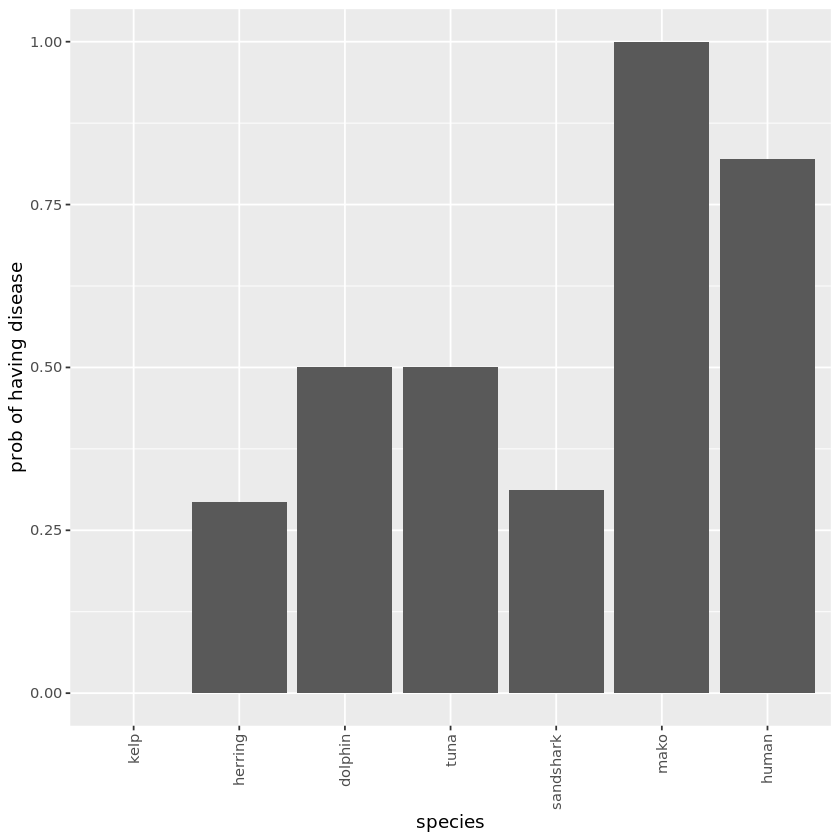

In [17]:
makeplot <- function(gen, plotname) {
    genplot <- gather(gen) %>% 
       mutate(species = factor(key, levels=speciesnames), gen=value) 

    pic <- genplot %>%
       ggplot(aes(x=species, y=value)) +
       scale_y_continuous(lim=c(0,1)) +  
       geom_col() + 
       theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
       xlab("species") +
       ylab("prob of having disease") 

    plot(pic)
}  

# plot generalizations across the food web 
makeplot(gen[1:n])

hypnum,kelp,herring,dolphin,tuna,sandshark,mako,human,prior,likelihood,posterior
123,2,2,2,2,1,2,1,0.0017221,1,0
124,2,2,2,2,1,2,2,0.0078452,1,0
125,2,2,2,2,2,1,1,0.0014649,1,0
126,2,2,2,2,2,1,2,0.0001628,1,0
127,2,2,2,2,2,2,1,0.0078452,1,0
128,2,2,2,2,2,2,2,0.0357393,1,0


hypnum,kelp,herring,dolphin,tuna,sandshark,mako,human,prior,likelihood,posterior
123,2,2,2,2,1,2,1,0.0017221,1,0.0017221
124,2,2,2,2,1,2,2,0.0078452,1,0.0078452
125,2,2,2,2,2,1,1,0.0014649,1,0.0014649
126,2,2,2,2,2,1,2,0.0001628,1,0.0001628
127,2,2,2,2,2,2,1,0.0078452,1,0.0078452
128,2,2,2,2,2,2,2,0.0357393,1,0.0357393


kelp,herring,dolphin,tuna,sandshark,mako,human
0.1,0.172,0.22384,0.22384,0.22384,0.3509443,0.3526799


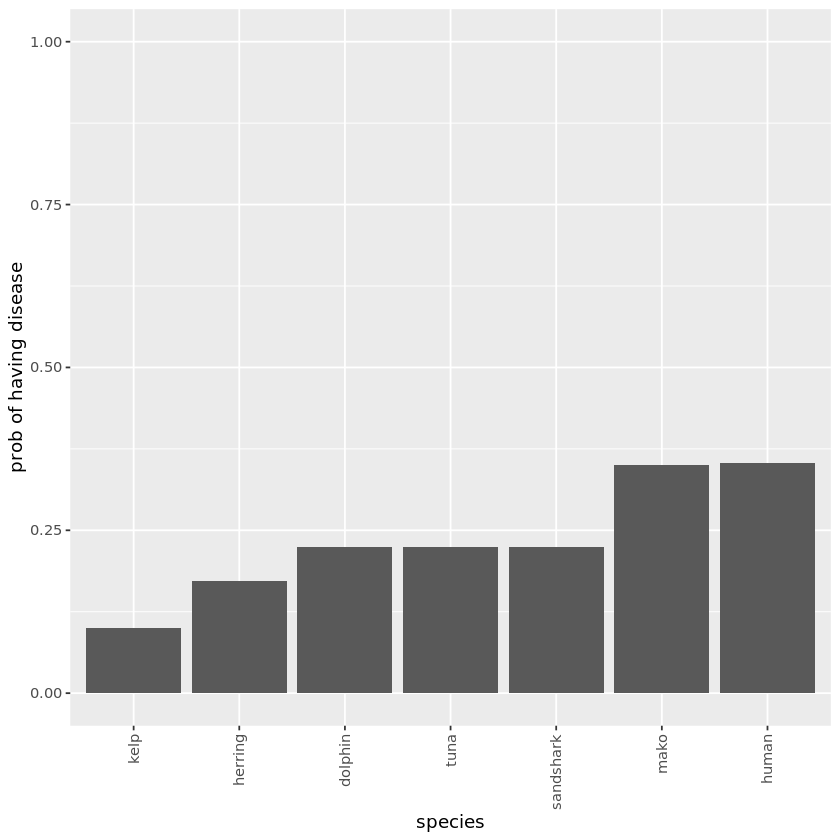

In [18]:
# Specify that kelp does not have the disease, but makos do
premises <- list()

# Compute likelihood p(premises|h) 
p_premises_given_h <- function(h, premises) {
  likelihood <- 1
  for (l in labels(premises)) {
    if (premises[l] != h[l]) {
      likelihood <-  0
    }
  }
  return(likelihood)
}

hs <- hs %>% 
  mutate(likelihood= map_dbl(hyp, p_premises_given_h, premises))


unnest(hs, cols = c(hyp))  %>% 
    tail()  %>% 
    show_table()


# compute posterior
hs <- hs %>% 
  # first compute an unnormalized posterior ...
  mutate(posterior = prior*likelihood) %>% 
  # then normalize so that it sums to 1
  mutate(posterior = posterior / sum(posterior))


unnest(hs, cols = c(hyp))  %>% 
    tail()  %>% 
    show_table()
# compute posterior predictive distribution: ie generalizations for each species in the foodweb

uhs <- unnest(hs, cols=c(hyp))

genlist <-list()
for( animalname in speciesnames ) {
    animalprob <- uhs %>% 
      # we need !!ensym() here because animalname is a variable instead of a column name 
      filter(!!ensym(animalname) == 2) %>% 
      summarize(aprob=sum(posterior)) %>% 
      pull()
    genlist[[animalname]] <- animalprob
}
gen <- as_tibble(genlist)

show_table(gen)
makeplot <- function(gen, plotname) {
    genplot <- gather(gen) %>% 
       mutate(species = factor(key, levels=speciesnames), gen=value) 

    pic <- genplot %>%
       ggplot(aes(x=species, y=value)) +
       scale_y_continuous(lim=c(0,1)) +  
       geom_col() + 
       theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
       xlab("species") +
       ylab("prob of having disease") 

    plot(pic)
}  

# plot generalizations across the food web 
makeplot(gen[1:n])

Given that mako have the disease but kelp do not, we see that humans are the species next most likely to have the disease.

### Question 3 (1 points)

(Any code for this question can be put in the previous cell)

Set the premise vector to an empty list: i.e. `premises <- list()`.  Run the model again to see what happens. You should see that humans are more likely to have the disease than kelp ---  why? 

For this and later questions that ask for an explanation, a compelling explanation in English is enough for full credit. If you can support your argument with mathematics that's great but not required.


YOUR ANSWER HERE

## Reasoning task 

We'll now apply the model to an experimental task used by Shafto et al (2008). These researchers first trained participants on the structure of the food web in Figure 1. They then asked participants to rate the strength of 42 single-premise arguments.  One such argument is "Herring have a disease. How likely is it that Mako have the same disease?" We can write this argument as Herring -> Mako. The set of 42 included all such arguments where the premise species (Herring in the example just given) was different from the conclusion species. Ratings were provided on a seven point scale.  

First let's define a function for evaluating the strength of an argument:

In [19]:
# compute P(conclusion_animal=2 | premise_animal=2) using the prior and likelihood in hs
rate_arg <- function(premise_animal, conclusion_animal, hs) {
  premises <- list()
  premises[[premise_animal]] <- 2
  
  arg_hs <- hs %>% 
    mutate(likelihood= map_dbl(hyp, p_premises_given_h, premises)) %>% 
    mutate(posterior = prior*likelihood) %>% 
    # normalise the posterior so that it sums to 1
    mutate(posterior = posterior / sum(posterior))
  
  conclusionprob <- arg_hs %>% 
    unnest(cols = c(hyp)) %>% 
    filter(!!ensym(conclusion_animal) == 2) %>% 
    summarize(cprob = sum(posterior)) %>% 
    pull()
}


Now read in a datafile that specifies the 42 arguments and includes the average human rating for each argument. We'll apply the model to each argument and plot human ratings against model predictions.

The human data here are very similar but perhaps not identical to the data used to generate the leftmost panel of Fig 9 of the Shafto et al paper. The differences are minor -- e.g. for the paper, a handful of people may have been dropped for using the rating scale backwards.

`geom_smooth()` using formula 'y ~ x'



premise,conclusion,human,model
human,herring,2.333333,0.3625121
mako,herring,3.222222,0.4379088
herring,kelp,2.888889,0.4767442
dolphin,herring,2.777778,0.6300929
sandshark,herring,2.222222,0.6300929
tuna,herring,3.000000,0.6300929
herring,human,2.333333,0.7433183
kelp,herring,4.111111,0.8200000
herring,dolphin,4.777778,0.8200000
herring,sandshark,4.555556,0.8200000


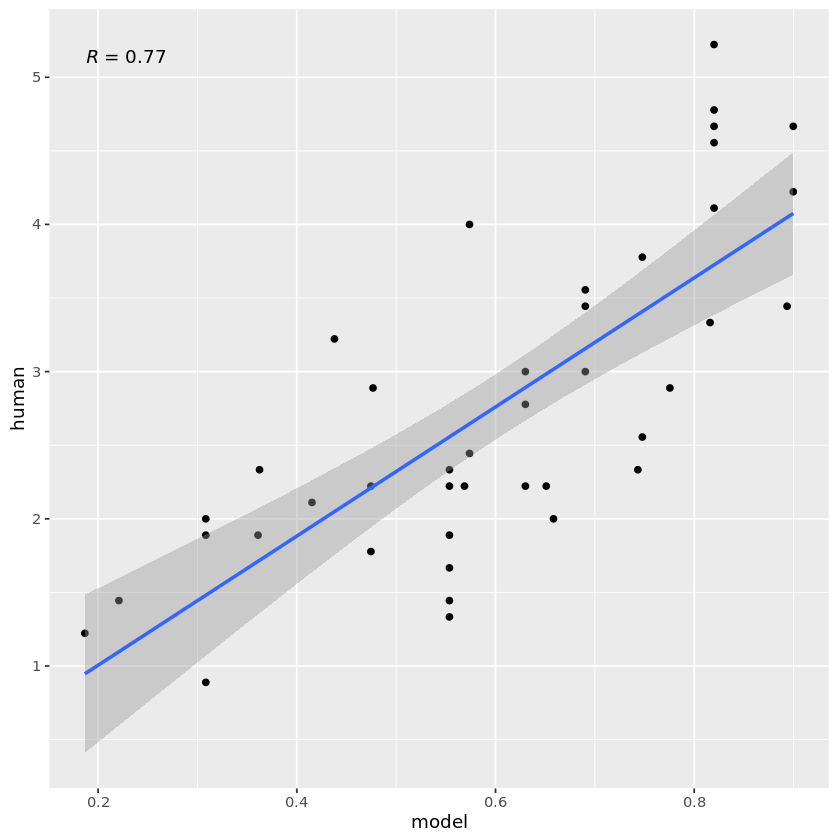

In [20]:
# now use model to rate all one premise arguments
onepremargs <- read_csv("data_foodwebarguments.csv", col_types="ccd") %>% 
  mutate(model = map2_dbl(premise, conclusion, rate_arg, hs))

humanmodelplot <- onepremargs %>% 
  ggplot(aes(x=model, y = human)) +
  geom_point() +
  geom_smooth(method = "lm") +
  stat_cor(aes(label=..r.label..), method = "pearson") +
  theme(aspect.ratio=1)

print(humanmodelplot)

onepremargs  %>% arrange(model)  %>% filter(premise == "herring" | conclusion == "herring")  %>% show_table()


In [21]:
onepremargs  %>% arrange(model)  %>% show_table()

premise,conclusion,human,model
human,kelp,1.2222222,0.1866840
mako,kelp,1.4444444,0.2209898
dolphin,kelp,2.0000000,0.3084346
sandshark,kelp,1.8888889,0.3084346
tuna,kelp,0.8888889,0.3084346
human,sandshark,1.8888889,0.3610087
human,herring,2.3333333,0.3625121
mako,sandshark,2.1111111,0.4152943
mako,herring,3.2222222,0.4379088
human,tuna,1.7777778,0.4746187


Each point corresponds to an argument. We've added a regression line to guide the eye and also included a correlation coefficient. You should see that there is a reasonably good correlation between human ratings and model predictions. In other words, arguments rated as strong by people tend to be given high probabilities according to the model.

### Question 4 (0.5 points)

(Any code for this question can be put in the previous cell)

Inspect the table that includes model predictions (`onepremargs`) and identify the argument that is strongest according to the model. If two or more arguments are equally strong, just pick one of them. What is the strongest argument? 


YOUR ANSWER HERE

### Question 5 (1 point)
Explain why this argument is strong according to the model.


YOUR ANSWER HERE

In [ ]:
# use this cell for any code you write for Question 6

### Question 6 (0.5 points)

(Any code for this question can be put in the previous cell)

Identify the argument that is weakest according to the model  (if two or more arguments are equally strong, just pick one of them). What is the weakest argument? 



YOUR ANSWER HERE

### Question 7 (1 point)

Explain why this argument is weak according to the model.


YOUR ANSWER HERE

In [ ]:
# use this cell for any code you write for Question 8

Causal asymmetry is the phenomenon that generalizations up the food chain (e.g. kelp -> herring tend to be stronger than generalizations in the opposite direction (herring -> kelp). 

### Question 8 (0.5 points)

(Any code for this question can be put in the previous cell)

What are the probabilities P(herring=2|kelp=2) and P(kelp=2|herring= 2) according to the model? 


YOUR ANSWER HERE

### Question 9 (1 point)

Explain why the model predicts that kelp -> herring is stronger than herring -> kelp


YOUR ANSWER HERE

In [ ]:
# use this cell for any code you write for Question 10

Causal distance is the phenomenon that generalizations tend to decrease with increasing distance in the food chain. 

### Question 10 (0.5 points)

(Any code for this question can be put in the previous cell)

What are the probabilities P(herring=2|kelp=2) and P(tuna= 2|kelp=2) according to the model?


YOUR ANSWER HERE

### Question 11 (1 point)

Explain why the model predicts that  kelp -> herring is stronger than kelp -> tuna.


YOUR ANSWER HERE

We'll now identify the arguments that lie furthest from the regression line, and are therefore least well captured by the model. We'll add a column `diff` that shows the vertical difference between the human rating and the corresponding point on the regression line. The variable `diff` will be positive for arguments that lie above the regression line in the scatterplot that you created.

In [ ]:
linearfit <- lm(human ~ model, data = onepremargs)

onepremargs_withfit <- onepremargs %>% 
  add_predictions(linearfit) %>% 
  mutate(diff = human - pred)


In [ ]:
# use this cell for any code you write for Question 12

### Question 12 (0.5 points)

(Any code for this question can be put in the previous cell)

What is the argument that lies at the greatest vertical distance above the regression line? 


YOUR ANSWER HERE

### Question 13 ( 1 point)

Why do you think people give such a strong rating to this argument -- what might they be doing that is not captured by the model?


YOUR ANSWER HERE